In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import sys
import cv2 as cv
from tqdm import tqdm
tqdm.pandas()

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'
cos_dat_fold = 'E:/cosmos-data'

### Importing My Data

In [3]:
df_cat = pd.read_csv(f'{combine_fold}/cosmos2020-categorised-interactions.csv', index_col = 0)

In [4]:
df_cat.head()

,ORyan23_ID,ID,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000705532455,816891,stage3,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-0.000010,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,4000705533383,861738,stage1,150.645118,2.237538,10033.689453,22720.843750,0.000039,0.000078,0.000013,...,-9.574272,-9.548649,-9.503962,-9.439343,-9.384205,0.240042,0.281559,0.330791,0.384371,0.436491
2,4000705539529,1284864,stage1,149.686223,2.637412,33027.406250,32317.517578,0.000031,0.000030,0.000001,...,-9.669377,-9.614943,-9.570104,-9.533121,-9.476167,0.094187,0.114436,0.140990,0.159430,0.183608
3,4000705539941,1301188,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-0.000003,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
4,4000705540034,1304538,stage1,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-0.000006,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727


In [74]:
df_red_tmp = df_cat.query('ez_sfr < 10')
df_red = df_red_tmp.query('lp_mass_best > 6.5')

### Reducing DataFrame

In [174]:
df_ra_dec = (
    df_red
    [['ORyan23_ID', 'ID', 'category', 'ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_zBEST', 'lp_mass_best', 'ez_sfr']]
)

In [175]:
def getting_duplicates(id_str, df):
    check = len(df.query('ORyan23_ID == @id_str'))
    if check > 1.5:
        return 'y'
    else:
        return 'n'

In [176]:
def picking_z(ez_z, lp_z):
    if np.isnan(ez_z):
        if not np.isnan(lp_z):
            return lp_z
        else:
            return np.nan
    
    if np.isnan(lp_z):
        if not np.isnan(ez_z):
            return ez_z
        else:
            return np.nan
    
    if lp_z < ez_z:
        return lp_z
    elif ez_z <= lp_z:
        return ez_z
    else:
        return 'what'

### Finding Duplicates

In [177]:
df_checked = (
    df_ra_dec
    .assign(coords = df_ra_dec.apply(lambda row: SkyCoord(ra = row.ALPHA_J2000 * u.deg, dec = row.DELTA_J2000 * u.deg, frame = 'fk5'), axis = 1))
    .assign(filt = df_ra_dec.ORyan23_ID.apply(lambda x: getting_duplicates(x, df_ra_dec)))
    .assign(z = df_ra_dec.apply(lambda row: picking_z(row.ez_z_phot, row.lp_zBEST), axis = 1))
)

In [178]:
df_filt = df_checked.query('filt == "y"').drop(columns = ['ez_z_phot', 'lp_zBEST'])
df_filt

,ORyan23_ID,ID,category,ALPHA_J2000,DELTA_J2000,lp_mass_best,ez_sfr,coords,filt,z
2237,4000705540005,1307416,stage3,149.723145,2.658653,10.35057,0.647159,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.442084
2238,4000708110752,958323,stage1,150.119051,2.324495,11.17791,1.026781,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.602500
2239,4000749509721,977735,stage2,149.881193,2.341328,9.62591,0.661792,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.792800
2240,4000767041112,792252,stage1,149.785875,2.172956,9.94800,0.649523,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.346103
2241,4000812790810,510098,stage4,149.493213,1.905151,9.56777,0.365039,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.299200
...,...,...,...,...,...,...,...,...,...,...
3791,6000535066150,1157587,stage4,150.422510,2.514655,10.56569,0.131293,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.671415
3792,6000535121452,1035987,stage1,149.694761,2.397231,9.83575,-0.122069,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.331183
3793,6000535865556,1138628,stage1,150.490889,2.496660,9.47153,0.220862,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.879100
3794,6000536013605,1203157,stage1,150.202813,2.558504,10.25633,0.975221,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.774100


In [179]:
bool_ser = df_filt.duplicated(subset='ORyan23_ID', keep='first')

In [206]:
df_prim = (
    df_filt[bool_ser]
    .drop(columns = 'filt')
    .rename(columns = {'ORyan23_ID': 'ORyan23_ID_1','ID': 'ID_Prim', 'category' : 'prim_cat', 'ALPHA_J2000': 'Prim_RA','DELTA_J2000' : 'Prim_Dec', 'coords' : 'prim_coords', 'z' : 'z_prim', 'ez_sfr':'ez_sfr_prim','lp_mass_best':'lp_mass_best_prim'})
)
df_sec = (
    df_filt[~bool_ser]
    .drop(columns = 'filt')
    .rename(columns = {'ORyan23_ID': 'ORyan23_ID_2', 'ID': 'ID_Sec', 'category' : 'sec_cat', 'ALPHA_J2000': 'Sec_RA','DELTA_J2000' : 'Sec_Dec', 'coords' : 'sec_coords', 'z' : 'z_sec', 'ez_sfr':'ez_sfr_sec','lp_mass_best':'lp_mass_best_sec'})
)

In [207]:
df_prim_sec = (
    df_prim.merge(df_sec, left_on = 'ORyan23_ID_1', right_on = 'ORyan23_ID_2', how = 'left')
)
df_prim_sec

,ORyan23_ID_1,ID_Prim,prim_cat,Prim_RA,Prim_Dec,lp_mass_best_prim,ez_sfr_prim,prim_coords,z_prim,ORyan23_ID_2,ID_Sec,sec_cat,Sec_RA,Sec_Dec,lp_mass_best_sec,ez_sfr_sec,sec_coords,z_sec
0,4175032695,352511,stage1,150.178767,1.750506,10.44980,0.221418,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.271055,4175032695,351054,stage1,150.180276,1.753549,9.73456,0.516089,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.284623
1,4575953945,1124323,stage4,149.687520,2.480424,9.76997,-0.232994,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.313699,4575953945,1118857,stage4,149.687643,2.477427,9.46014,-0.202330,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.305336
2,4651333659,718770,stage1,149.818503,2.102772,10.74354,0.730193,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.632000,4651333659,714303,stage1,149.817268,2.103133,9.82053,0.769956,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.658200
3,4000705540005,1305894,stage3,149.722207,2.660240,10.85063,0.638292,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",1.445788,4000705540005,1307416,stage3,149.723145,2.658653,10.35057,0.647159,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.442084
4,4000708110752,959618,stage1,150.119472,2.322125,10.97378,-1.020907,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.600800,4000708110752,958323,stage1,150.119051,2.324495,11.17791,1.026781,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.602500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,6000535066150,1157587,stage4,150.422510,2.514655,10.56569,0.131293,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.671415,6000535066150,1157455,stage4,150.422657,2.512777,10.37112,1.029161,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.670400
743,6000535121452,1035987,stage1,149.694761,2.397231,9.83575,-0.122069,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.331183,6000535121452,1042177,stage1,149.693918,2.396792,10.22087,0.512719,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.374718
744,6000535865556,1138628,stage1,150.490889,2.496660,9.47153,0.220862,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.879100,6000535865556,1144648,stage1,150.492010,2.497863,11.11127,0.343823,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.883193
745,6000536013605,1203157,stage1,150.202813,2.558504,10.25633,0.975221,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.774100,6000536013605,1203158,stage1,150.202121,2.559187,9.39806,0.615512,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.755400


In [208]:
df_check = (
    df_prim_sec
    .assign(check = df_prim_sec.apply(lambda row: 'n' if row.ORyan23_ID_1 != row.ORyan23_ID_2 else 'y', axis = 1))
)

In [209]:
df_check.check.value_counts()

y    747
Name: check, dtype: int64

### Checking Z-Differences

In [210]:
df_z_check = (
    df_prim_sec
    .assign(z_diff = df_prim_sec.apply(lambda row: row.z_prim - row.z_sec, axis = 1))
)

In [211]:
len(df_z_check)

747

In [212]:
df_z_checked = df_z_check.query('z_diff >= -0.1 and z_diff <= 0.1')

In [213]:
df_z_checked

,ORyan23_ID_1,ID_Prim,prim_cat,Prim_RA,Prim_Dec,lp_mass_best_prim,ez_sfr_prim,prim_coords,z_prim,ORyan23_ID_2,ID_Sec,sec_cat,Sec_RA,Sec_Dec,lp_mass_best_sec,ez_sfr_sec,sec_coords,z_sec,z_diff
0,4175032695,352511,stage1,150.178767,1.750506,10.44980,0.221418,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.271055,4175032695,351054,stage1,150.180276,1.753549,9.73456,0.516089,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.284623,-0.013568
1,4575953945,1124323,stage4,149.687520,2.480424,9.76997,-0.232994,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.313699,4575953945,1118857,stage4,149.687643,2.477427,9.46014,-0.202330,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.305336,0.008364
2,4651333659,718770,stage1,149.818503,2.102772,10.74354,0.730193,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.632000,4651333659,714303,stage1,149.817268,2.103133,9.82053,0.769956,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.658200,-0.026200
4,4000708110752,959618,stage1,150.119472,2.322125,10.97378,-1.020907,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.600800,4000708110752,958323,stage1,150.119051,2.324495,11.17791,1.026781,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.602500,-0.001700
5,4000749509721,971994,stage2,149.881535,2.340141,9.41265,0.694530,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.751300,4000749509721,977735,stage2,149.881193,2.341328,9.62591,0.661792,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.792800,-0.041500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,6000535008523,1016112,stage1,150.027738,2.373879,11.30303,-2.347923,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.226895,6000535008523,1018703,stage1,150.028460,2.375080,10.52583,0.590401,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.225256,0.001639
742,6000535066150,1157587,stage4,150.422510,2.514655,10.56569,0.131293,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.671415,6000535066150,1157455,stage4,150.422657,2.512777,10.37112,1.029161,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.670400,0.001015
743,6000535121452,1035987,stage1,149.694761,2.397231,9.83575,-0.122069,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.331183,6000535121452,1042177,stage1,149.693918,2.396792,10.22087,0.512719,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.374718,-0.043535
744,6000535865556,1138628,stage1,150.490889,2.496660,9.47153,0.220862,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.879100,6000535865556,1144648,stage1,150.492010,2.497863,11.11127,0.343823,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.883193,-0.004093


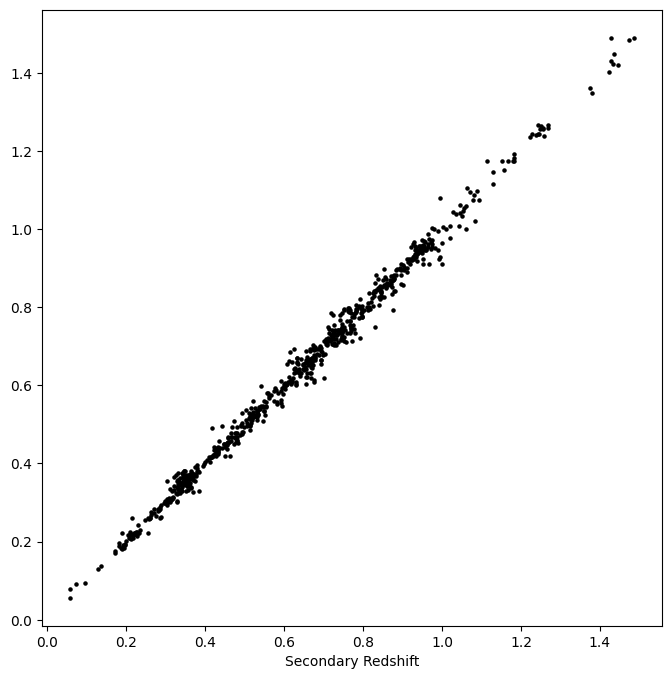

In [214]:
plt.figure(figsize = (8,8))
plt.scatter(df_z_checked.z_prim, df_z_checked.z_sec, s = 5, color = 'black')
plt.xlabel('Primary Redshift')
plt.xlabel('Secondary Redshift')

plt.show()

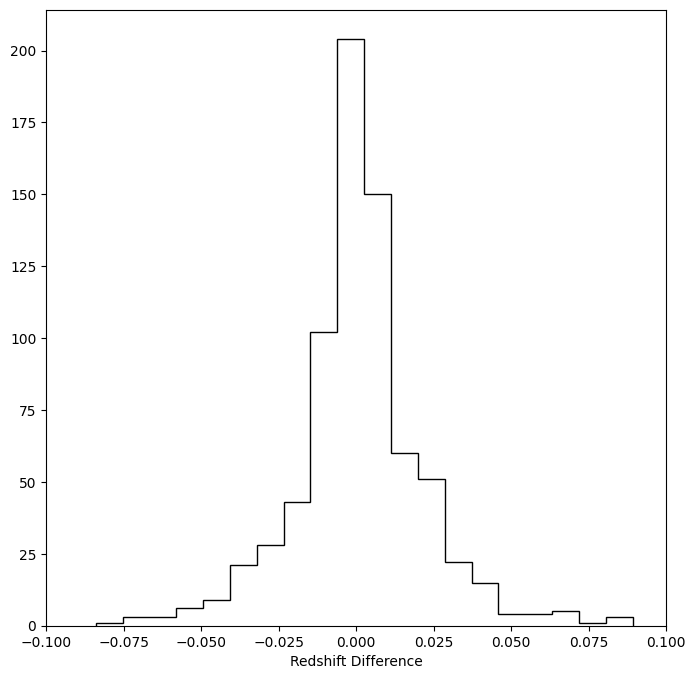

In [215]:
plt.figure(figsize = (8,8))
plt.hist(df_z_checked.z_diff, bins = 20, color = 'black', histtype='step')
plt.xlabel('Redshift Difference')
plt.xlim([-0.1,0.1])
plt.show()

### Getting Projected Separations

In [216]:
df_seps = (
    df_z_checked
    .assign(proj_seps = df_z_checked.apply(lambda row: np.float64(((row.prim_coords.separation(row.sec_coords)).to(u.arcsec)) / u.arcsec), axis = 1))
)
df_seps

,ORyan23_ID_1,ID_Prim,prim_cat,Prim_RA,Prim_Dec,lp_mass_best_prim,ez_sfr_prim,prim_coords,z_prim,ORyan23_ID_2,ID_Sec,sec_cat,Sec_RA,Sec_Dec,lp_mass_best_sec,ez_sfr_sec,sec_coords,z_sec,z_diff,proj_seps
0,4175032695,352511,stage1,150.178767,1.750506,10.44980,0.221418,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.271055,4175032695,351054,stage1,150.180276,1.753549,9.73456,0.516089,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.284623,-0.013568,12.226211
1,4575953945,1124323,stage4,149.687520,2.480424,9.76997,-0.232994,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.313699,4575953945,1118857,stage4,149.687643,2.477427,9.46014,-0.202330,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.305336,0.008364,10.798358
2,4651333659,718770,stage1,149.818503,2.102772,10.74354,0.730193,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.632000,4651333659,714303,stage1,149.817268,2.103133,9.82053,0.769956,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.658200,-0.026200,4.630426
4,4000708110752,959618,stage1,150.119472,2.322125,10.97378,-1.020907,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.600800,4000708110752,958323,stage1,150.119051,2.324495,11.17791,1.026781,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.602500,-0.001700,8.666442
5,4000749509721,971994,stage2,149.881535,2.340141,9.41265,0.694530,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.751300,4000749509721,977735,stage2,149.881193,2.341328,9.62591,0.661792,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.792800,-0.041500,4.445862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,6000535008523,1016112,stage1,150.027738,2.373879,11.30303,-2.347923,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.226895,6000535008523,1018703,stage1,150.028460,2.375080,10.52583,0.590401,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.225256,0.001639,5.043280
742,6000535066150,1157587,stage4,150.422510,2.514655,10.56569,0.131293,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.671415,6000535066150,1157455,stage4,150.422657,2.512777,10.37112,1.029161,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.670400,0.001015,6.781172
743,6000535121452,1035987,stage1,149.694761,2.397231,9.83575,-0.122069,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.331183,6000535121452,1042177,stage1,149.693918,2.396792,10.22087,0.512719,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.374718,-0.043535,3.418663
744,6000535865556,1138628,stage1,150.490889,2.496660,9.47153,0.220862,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.879100,6000535865556,1144648,stage1,150.492010,2.497863,11.11127,0.343823,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.883193,-0.004093,5.916610


In [217]:
df_seps.proj_seps.min()

1.028944717143494

In [218]:
df_seps.proj_seps.max()

16.334642338362816

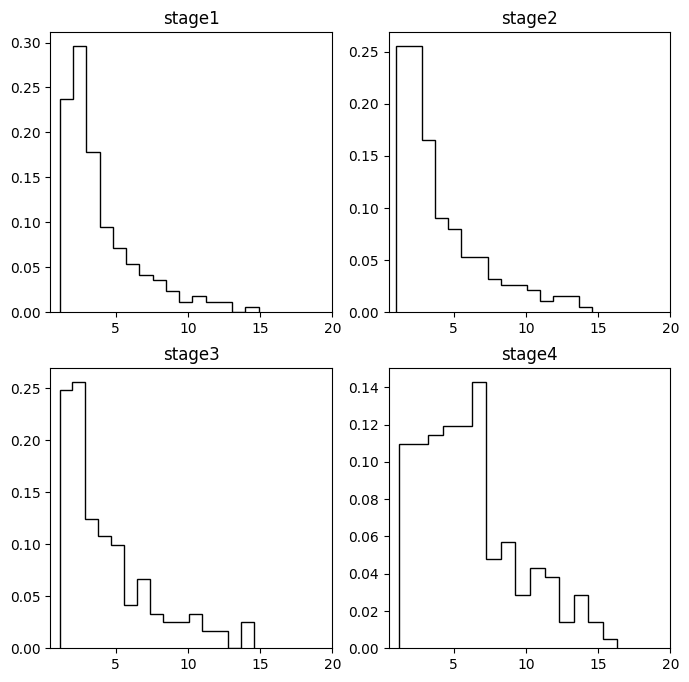

In [219]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        proj_seps = np.array(df_seps.query('prim_cat == @stage').proj_seps)
        
        ax[i,j].hist(proj_seps, bins = 15, histtype='step', color='black', density = True)
        ax[i,j].set_title(stage)
        ax[i,j].set_xlim([0.5, 20])
        
        counter += 1

### Checking Actual Separations

In [220]:
df_z_checked.head()

,ORyan23_ID_1,ID_Prim,prim_cat,Prim_RA,Prim_Dec,lp_mass_best_prim,ez_sfr_prim,prim_coords,z_prim,ORyan23_ID_2,ID_Sec,sec_cat,Sec_RA,Sec_Dec,lp_mass_best_sec,ez_sfr_sec,sec_coords,z_sec,z_diff
0,4175032695,352511,stage1,150.178767,1.750506,10.44980,0.221418,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.271055,4175032695,351054,stage1,150.180276,1.753549,9.73456,0.516089,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.284623,-0.013568
1,4575953945,1124323,stage4,149.687520,2.480424,9.76997,-0.232994,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.313699,4575953945,1118857,stage4,149.687643,2.477427,9.46014,-0.202330,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.305336,0.008364
2,4651333659,718770,stage1,149.818503,2.102772,10.74354,0.730193,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.632000,4651333659,714303,stage1,149.817268,2.103133,9.82053,0.769956,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.658200,-0.026200
4,4000708110752,959618,stage1,150.119472,2.322125,10.97378,-1.020907,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.600800,4000708110752,958323,stage1,150.119051,2.324495,11.17791,1.026781,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.602500,-0.001700
5,4000749509721,971994,stage2,149.881535,2.340141,9.41265,0.694530,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.751300,4000749509721,977735,stage2,149.881193,2.341328,9.62591,0.661792,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.792800,-0.041500


In [221]:
def get_physical_seps(prim_ra, prim_dec, prim_z, sec_ra, sec_dec, sec_z, cosmo):
    d1 = cosmo.comoving_distance(prim_z)
    d2 = cosmo.comoving_distance(sec_z)
    
    coord_1 = SkyCoord(ra = prim_ra * u.deg, dec = prim_dec * u.deg, frame = 'fk5', distance = d1)
    coord_2 = SkyCoord(ra = sec_ra * u.deg, dec = sec_dec * u.deg, frame = 'fk5', distance = d2)
    
    physical_sep = coord_1.separation_3d(coord_2).to(u.kpc)
    
    return np.float64(physical_sep / u.kpc)

In [222]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.275 * u.K, Om0 = 0.308)

In [269]:
df_seps = (
    df_z_checked
    .assign(seps = df_z_checked.progress_apply(lambda row: get_physical_seps(row.Prim_RA, row.Prim_Dec, row.z_prim, row.Sec_RA, row.Sec_Dec, row.z_prim, cosmo), axis = 1))
)

100%|██████████| 735/735 [00:01<00:00, 472.54it/s]


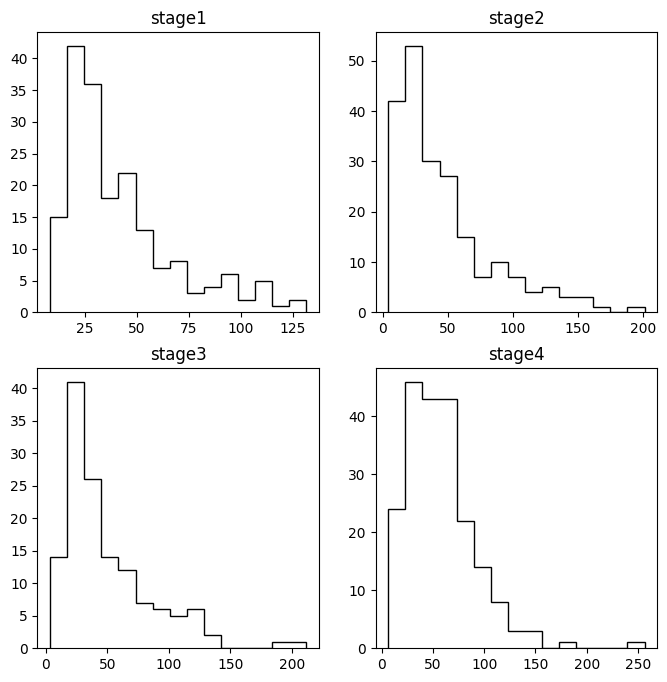

In [270]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        proj_seps = np.array(df_seps.query('prim_cat == @stage').seps)
        
        ax[i,j].hist(proj_seps, bins = 15, histtype='step', color='black')
        ax[i,j].set_title(stage)
        # ax[i,j].set_xlim([0,225])
        
        counter += 1

### Star Formation with Projected Separation

In [271]:
df_seps_red = (
    df_seps[['ORyan23_ID_1', 'ID_Prim', 'ID_Sec', 'z_prim', 'z_sec', 'lp_mass_best_prim', 'lp_mass_best_sec', 'ez_sfr_prim', 'ez_sfr_sec', 'seps', 'prim_cat']]
)

In [272]:
def adding_logs(logx1, logx2):
    x1 = 10**logx1
    x2 = 10**logx2
    x_sum = x1 + x2
    return np.log10(x_sum)

In [273]:
df_sfrs = (
    df_seps_red
    .assign(mass_tot = df_seps_red.apply(lambda row: adding_logs(row.lp_mass_best_prim, row.lp_mass_best_sec), axis = 1))
    .assign(sfr_tot = df_seps_red.apply(lambda row: adding_logs(row.ez_sfr_prim, row.ez_sfr_sec), axis = 1))
)

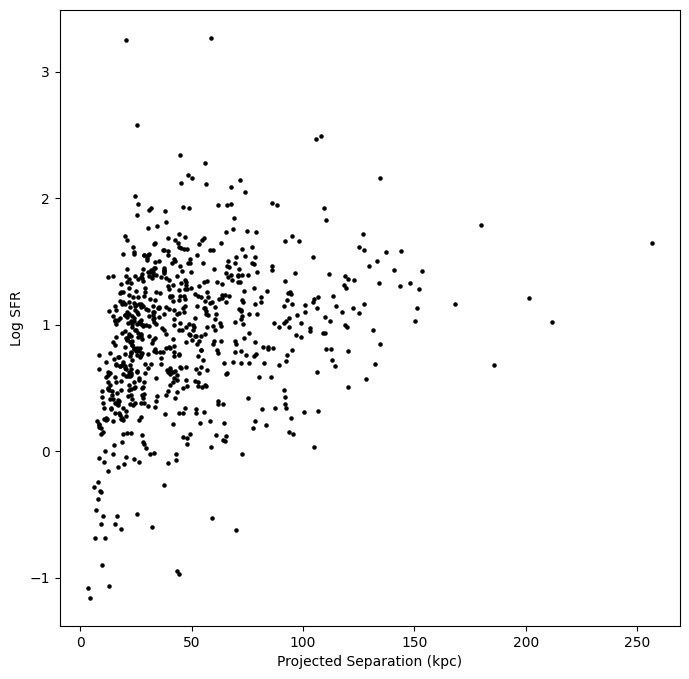

In [274]:
plt.figure(figsize = (8,8))
plt.scatter(df_sfrs.seps, df_sfrs.sfr_tot, s = 5, color = 'black')
plt.xlabel('Projected Separation (kpc)')
plt.ylabel('Log SFR')
plt.show()

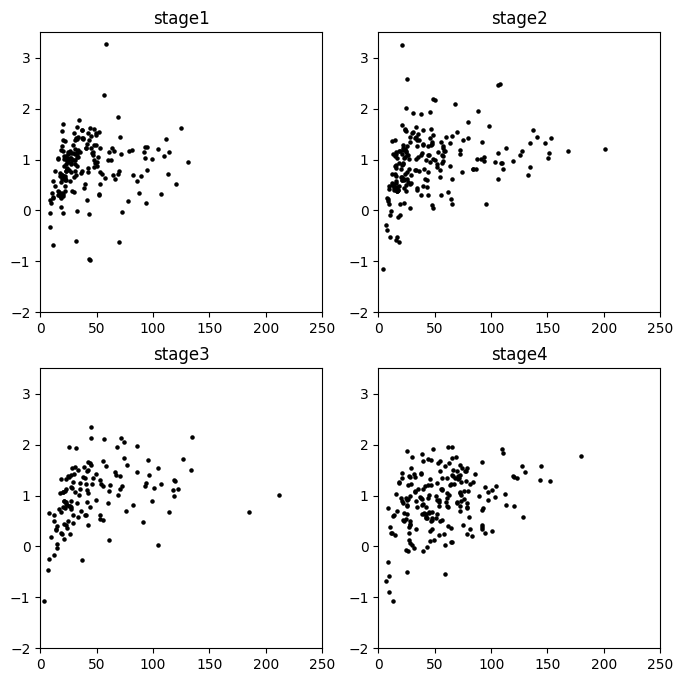

In [275]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_sfrs.query('prim_cat == @stage')
        
        ax[i,j].scatter(df_stage.seps, df_stage.sfr_tot, s=5, color='black')
        ax[i,j].set_title(stage)
        ax[i,j].set_xlim([0, 250])
        ax[i,j].set_ylim([-2,3.5])
        
        counter += 1

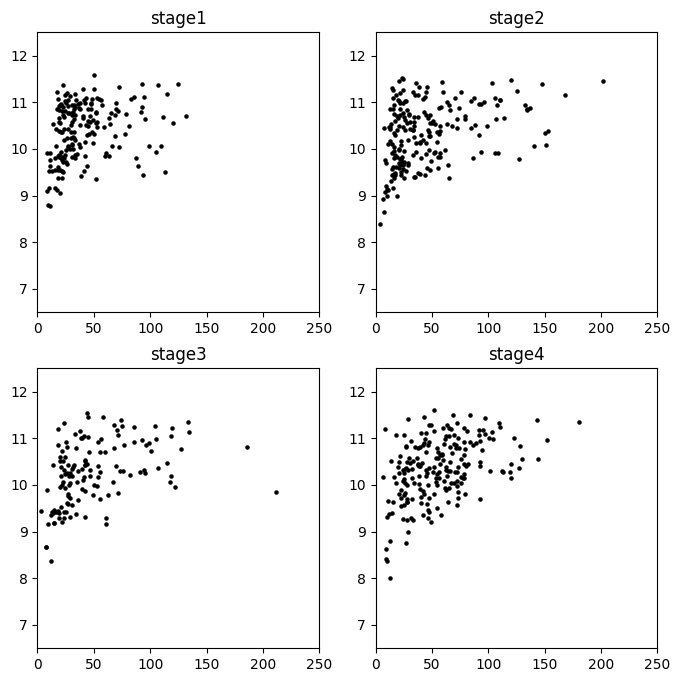

In [276]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_sfrs.query('prim_cat == @stage')
        
        ax[i,j].scatter(df_stage.seps, df_stage.mass_tot, s=5, color='black')
        ax[i,j].set_title(stage)
        ax[i,j].set_xlim([0, 250])
        ax[i,j].set_ylim([6.5,12.5])
        
        counter += 1